In [1]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import sklearn
from scipy.optimize import curve_fit
import re
import ipywidgets as widgets

import os
import sys
sys.path.append('../batteryratecap')
import visualization

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
Battery_Parameter = pd.read_excel('../doc/Data/parameterlog.xls', sheet_name=None)
Battery_Parameter_sheet_names = pd.ExcelFile('../doc/Data/parameterlog.xls').sheet_names
Battery_Parameter_sheet_names
for i, j in enumerate(Battery_Parameter_sheet_names):
    globals()[f'Battery_Parameter_{j}'] = Battery_Parameter[Battery_Parameter_sheet_names[i]]

###### Preview pandas dataframes

In [4]:
Battery_Parameter_MaterialParameters

,Paper #,Set,Cathode Material,Anode Material,Electrolyte Material,Cathode \nParticle Max. \nDiameter [µm],Cathode \nParticle Ave.\nDiameter [µm],Cathode \nParticle Min. \nDiameter [µm],Anode \nParticle Max. \nDiameter [µm],Anode \nParticle Ave. \nDiameter [µm],Anode \nParticle Min. \nDiameter [µm]
0,1,1,LiFePO4,Lithium,Ionogel,N/R,NaN,NaN,N/R,NaN,NaN
1,2,1,Lithium foil,Silver,1M LiPF6 in EC:PC:EMC 1:1:3,N/R,N/R,N/R,0.03,N/R,0.05
2,2,2,Lithium foil,Silver,1M LiPF6 in EC:PC:EMC 1:1:3,N/R,N/R,N/R,0.03,N/R,0.05
3,2,3,Lithium foil,Silver,1M LiPF6 in EC:PC:EMC 1:1:3,N/R,N/R,N/R,0.03,N/R,0.05
4,2,4,Lithium foil,Silver,1M LiPF6 in EC:PC:EMC 1:1:3,N/R,N/R,N/R,0.03,N/R,0.05
...,...,...,...,...,...,...,...,...,...,...,...
85,35,8,LiMnO2 on porous Ni,NiSn on porous Ni,1M LiClO4 EC : DEC in 1:1 wt ratio,N/R,N/R,N/R,N/R,N/R,N/R
86,37,1,LMO,NiSn on porous Ni,1M LiClO4 EC : DEC in 1:1 wt ratio,N/R,100,N/R,N/R,70,N/R
87,37,2,LMO,NiSn on porous Ni,1M LiClO4 EC : DEC in 1:1 wt ratio,N/R,100,N/R,N/R,70,N/R
88,37,3,LMO,NiSn on porous Ni,1M LiClO4 EC : DEC in 1:1 wt ratio,N/R,100,N/R,N/R,70,N/R


In [5]:
Battery_Parameter_GeometryParameters

,Paper #,Set,Full Cell \nThickness [µm],Cathode \nThickness [µm],Anode \nThickness [µm],Separator \nThickness [µm]
0,1,1,NaN,500,N/R,N/R
1,2,1,NaN,N/R,215,N/R
2,2,2,NaN,N/R,415,N/R
3,2,3,NaN,N/R,265,N/R
4,2,4,NaN,N/R,473,N/R
...,...,...,...,...,...,...
86,36,1,NaN,NaN,NaN,NaN
87,37,1,10,10,10,N/R
88,37,2,10,10,10,N/R
89,37,3,10,10,10,N/R


### Load all Curve fitting parameters

In [6]:
fit_df = pd.read_csv('../doc/Data/fitparameters.csv')
par_df = fit_df[{'Paper #','Set','n','tau','Q'}]

In [7]:
par_df

,tau,Paper #,Q,Set,n
0,0.485641,1.0,106.109020,1.0,1.302511
1,0.487356,1.0,105.112479,1.0,1.171666
2,0.000000,4.0,0.000000,1.0,0.000000
3,0.000000,4.0,0.000000,2.0,0.000000
4,0.000000,4.0,0.000000,3.0,0.000000
5,0.000000,11.0,0.000000,1.0,0.000000
6,0.000000,11.0,0.000000,2.0,0.000000
7,0.000000,11.0,0.000000,3.0,0.000000
8,0.000000,11.0,0.000000,4.0,0.000000
9,0.000000,11.0,0.000000,5.0,0.000000


### Plot histograms to show distributions of n and tau
Figure 2(f) in Tian's paper

Text(0, 0.5, 'number of cases')

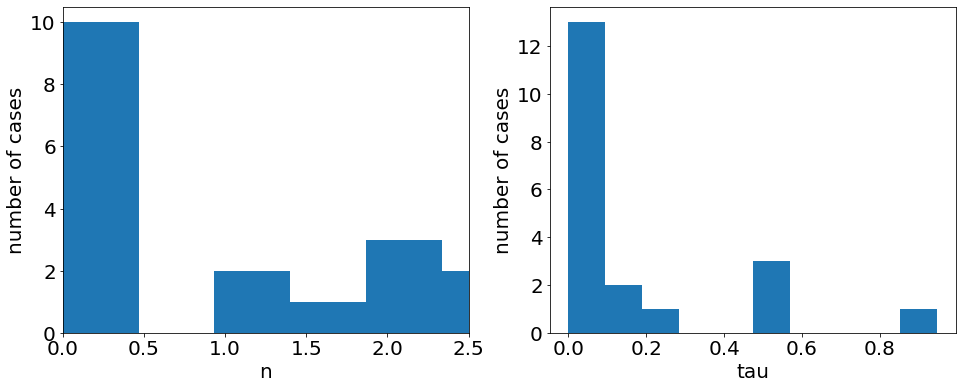

In [8]:
matplotlib.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=(16,6))
ax = fig.subplots(nrows=1,ncols=2)

ax[0].hist(par_df['n'].values)
ax[0].set_xlabel('n')
ax[0].set_xlim(0,2.5)
ax[0].set_ylabel('number of cases')
ax[1].hist(par_df['tau'].values)
ax[1].set_xlabel('tau')
ax[1].set_ylabel('number of cases')

In [9]:
visualization_df = pd.merge(par_df, Battery_Parameter_GeometryParameters, how="outer", on=['Paper #','Set'])
visualization_df.head()

,tau,Paper #,Q,Set,n,Full Cell \nThickness [µm],Cathode \nThickness [µm],Anode \nThickness [µm],Separator \nThickness [µm]
0,0.485641,1.0,106.109020,1.0,1.302511,NaN,500,N/R,N/R
1,0.487356,1.0,105.112479,1.0,1.171666,NaN,500,N/R,N/R
2,0.000000,4.0,0.000000,1.0,0.000000,N/R,550,N/R,N/R
3,0.000000,4.0,0.000000,2.0,0.000000,N/R,350,N/R,N/R
4,0.000000,4.0,0.000000,3.0,0.000000,N/R,350,N/R,N/R


In [10]:
# Replace NaN values
visualization_df = visualization_df.replace(['N/R'], np.NaN)
visualization_df
visualization_df.to_csv('../doc/Data/visualization_df.csv')

### Load Geometry and Material Parameters

In [11]:
features = list(visualization_df.columns[5:])
features

['Full Cell \nThickness [µm]',
 'Cathode \nThickness [µm]',
 'Anode \nThickness [µm] ',
 'Separator \nThickness [µm]']

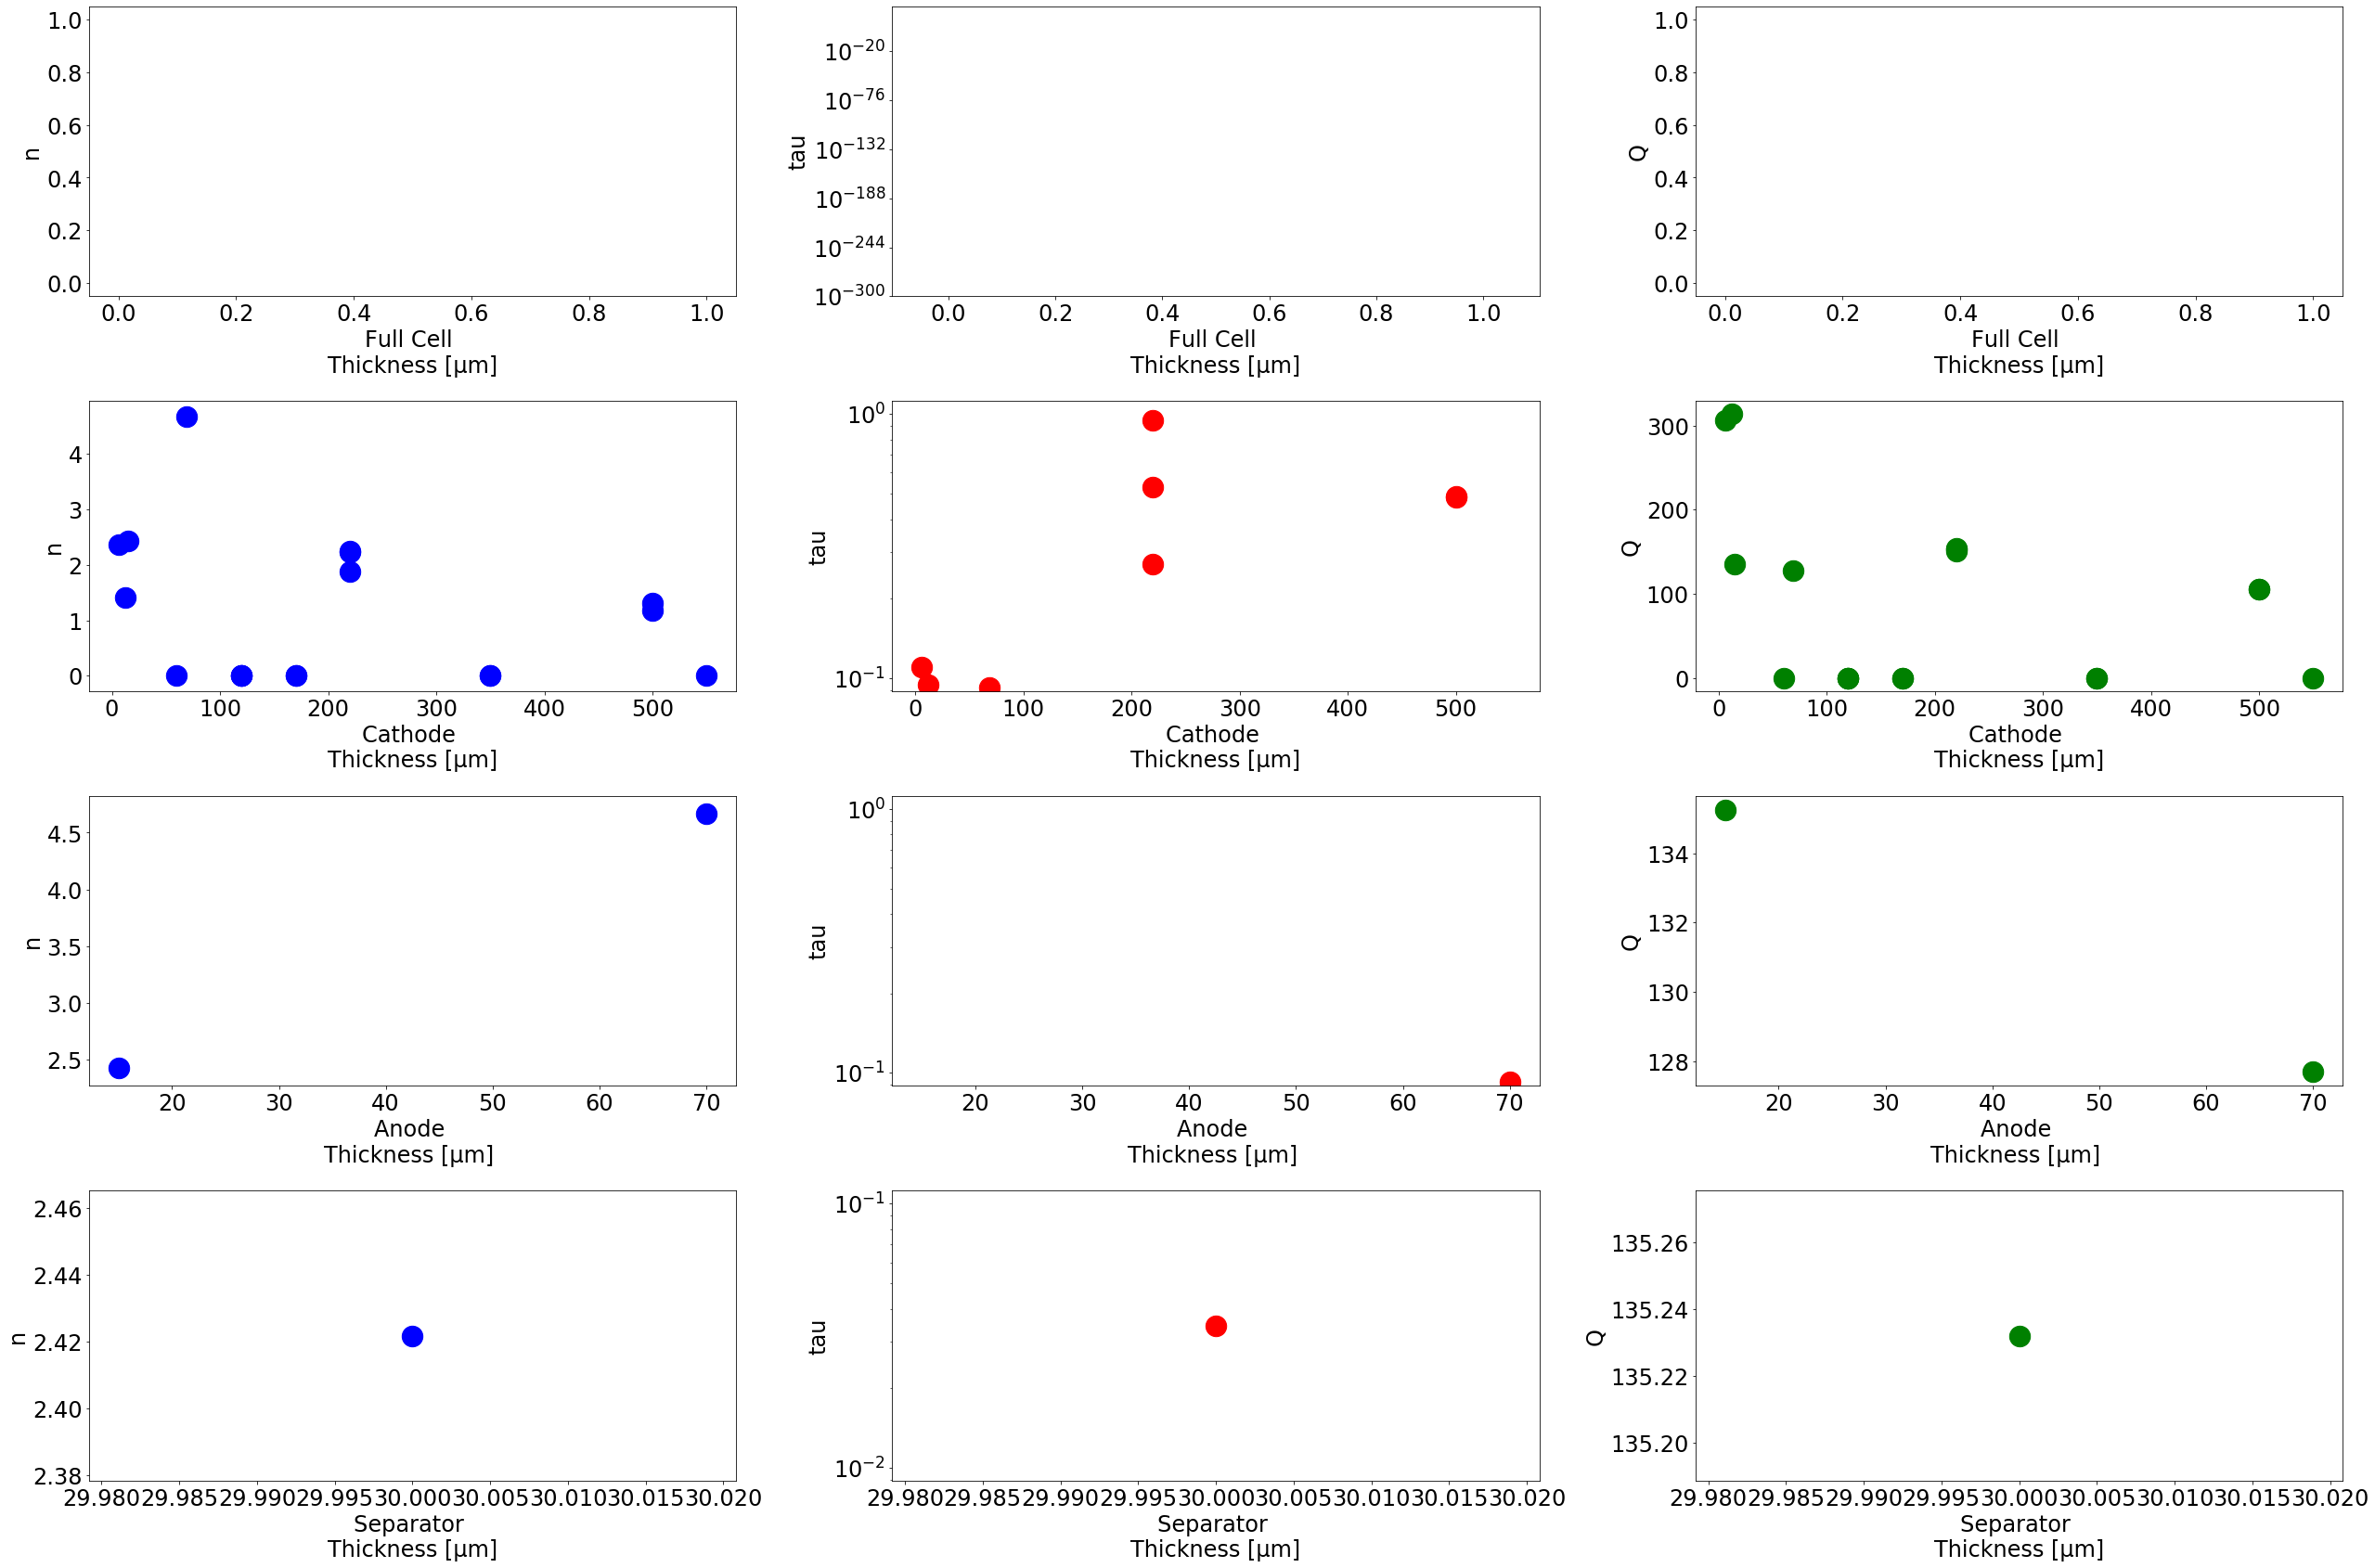

In [12]:
visualization.feature_vs_n_tau_Q(visualization_df, features)